In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import random
from sklearn.metrics import roc_auc_score, roc_curve

In [11]:
# Set random seeds for reproducibility
RANDOM_STATE = 24  # 24 leads to a lower error than 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

In [12]:
train = pd.read_csv('../data/PCA-nsl_kdd_train.csv')
test = pd.read_csv('../data/PCA-nsl_kdd_test.csv')

In [13]:
# 53% normal attack_type
train['attack_flag'].describe()

count    125973.000000
mean          0.465417
std           0.498805
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: attack_flag, dtype: float64

In [14]:
# 43% normal attack_type
test['attack_flag'].describe()

count    22544.000000
mean         0.569242
std          0.495193
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: attack_flag, dtype: float64

In [15]:
y_train = train['attack_flag'].astype(int)  # normal = 0, anomaly = 1
y_test = test['attack_flag'].astype(int)

X_train = train.drop('attack_flag', axis=1)[y_train == 0].values  # train only on normal data
X_test = test.drop('attack_flag', axis=1).values  # test on normal and attack data

In [16]:
X_train.shape

(67343, 18)

In [17]:
X_test.shape

(22544, 18)

In [18]:
# Split normal training data into train/validation for early stopping
from sklearn.model_selection import train_test_split

X_train_split, X_val_split = train_test_split(X_train, test_size=0.15, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_split)
X_val_tensor = torch.FloatTensor(X_val_split)
X_test_tensor = torch.FloatTensor(X_test)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, X_train_tensor)  # (input, target), same for autoencoders
val_dataset = TensorDataset(X_val_tensor, X_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

# Autoencoder
Autoencoders train only on normal network traffic. Their job is to attempt to compress then  
reconstruct the given input.  

To tell if something is an anomaly we measure reconstruction error, which increases when the model  
encounters non-normal network traffic because it did not train on those samples.

#### Architecture:  
  Input: 18 (PCA features)  
    ↓  
  Encoder: 18 → 12 → 8 (bottleneck)  
    ↓  
  Decoder: 8 → 12 → 18  
    ↓  
  Output: 18 (reconstructed)  

Using gradual compression instead of jumping directly down to 8.

In [19]:
class Autoencoder(nn.Module):
  def __init__(self, input_dim=18, hidden_dim=14, encoding_dim=8, dropout=0.15):
    super(Autoencoder, self).__init__()
    # Encoder
    self.encoder = nn.Sequential(
      nn.Linear(input_dim, hidden_dim), nn.ReLU(), nn.Dropout(dropout),
      nn.Linear(hidden_dim, encoding_dim), nn.ReLU()
    )
    # Decoder
    self.decoder = nn.Sequential(
      nn.Linear(encoding_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, input_dim)
    )

    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.encoding_dim = encoding_dim

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

## Initialize the model

In [20]:
# Initialize model
input_dim = X_train_split.shape[1]
model = Autoencoder(input_dim=input_dim, hidden_dim=14, encoding_dim=8)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-3)

print(f'Model: {input_dim} → {model.hidden_dim} → {model.encoding_dim} → {model.hidden_dim} → {input_dim}')
print(f'Training samples: {X_train_tensor.shape[0]}')
print(f'Validation samples: {X_val_tensor.shape[0]}')

Model: 18 → 14 → 8 → 14 → 18
Training samples: 57241
Validation samples: 10102


## Train the model

In [21]:
# Training loop with early stopping
num_epochs = 300
patience = 15  # Stop if no improvement for 10 epochs
min_delta = 1e-5  # Minimum improvement to count as progress

train_losses = []
val_losses = []
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

for epoch in range(num_epochs):
  # Training phase
  model.train()
  epoch_train_loss = 0
  for batch_data, batch_target in train_loader:
    reconstructed = model(batch_data)
    loss = criterion(reconstructed, batch_target)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epoch_train_loss += loss.item()

  avg_train_loss = epoch_train_loss / len(train_loader)
  train_losses.append(avg_train_loss)

  # Validation phase
  model.eval()
  epoch_val_loss = 0
  with torch.no_grad():
    for batch_data, batch_target in val_loader:
      reconstructed = model(batch_data)
      loss = criterion(reconstructed, batch_target)
      epoch_val_loss += loss.item()

  avg_val_loss = epoch_val_loss / len(val_loader)
  val_losses.append(avg_val_loss)

  # Early stopping check
  improvement = ''
  if avg_val_loss < best_val_loss - min_delta:
    best_val_loss = avg_val_loss
    patience_counter = 0
    best_model_state = model.state_dict().copy()
    improvement = '✅'
  else:
    patience_counter += 1
    improvement = ''

  # Print progress
  if (epoch + 1) % 10 == 0 or patience_counter == 0:
    print(
      f'Epoch [{epoch + 1}/{num_epochs}] | Train Loss: {avg_train_loss:.6f} | '
      f'Val Loss: {avg_val_loss:.6f} {improvement}'
    )

  # Stop if patience exceeded
  if patience_counter >= patience:
    print(f'\nEarly stopping triggered at epoch {epoch + 1}')
    print(f'Best validation loss: {best_val_loss:.6f}')
    break

# Restore best model
if best_model_state is not None:
  model.load_state_dict(best_model_state)
  print(f'\nRestored best model from epoch {epoch + 1 - patience_counter}')

print('Training complete!')

Epoch [1/300] | Train Loss: 1.229902 | Val Loss: 0.910190 ✅
Epoch [2/300] | Train Loss: 0.831184 | Val Loss: 0.749842 ✅
Epoch [3/300] | Train Loss: 0.693327 | Val Loss: 0.656969 ✅
Epoch [4/300] | Train Loss: 0.605659 | Val Loss: 0.558249 ✅
Epoch [5/300] | Train Loss: 0.545673 | Val Loss: 0.501737 ✅
Epoch [6/300] | Train Loss: 0.508290 | Val Loss: 0.461437 ✅
Epoch [7/300] | Train Loss: 0.478345 | Val Loss: 0.421143 ✅
Epoch [8/300] | Train Loss: 0.459100 | Val Loss: 0.394478 ✅
Epoch [9/300] | Train Loss: 0.421646 | Val Loss: 0.374880 ✅
Epoch [10/300] | Train Loss: 0.418437 | Val Loss: 0.352939 ✅
Epoch [11/300] | Train Loss: 0.403713 | Val Loss: 0.334125 ✅
Epoch [12/300] | Train Loss: 0.393960 | Val Loss: 0.332844 ✅
Epoch [13/300] | Train Loss: 0.373419 | Val Loss: 0.322805 ✅
Epoch [14/300] | Train Loss: 0.385077 | Val Loss: 0.316979 ✅
Epoch [15/300] | Train Loss: 0.364161 | Val Loss: 0.306007 ✅
Epoch [16/300] | Train Loss: 0.349961 | Val Loss: 0.297621 ✅
Epoch [17/300] | Train Loss: 0.34

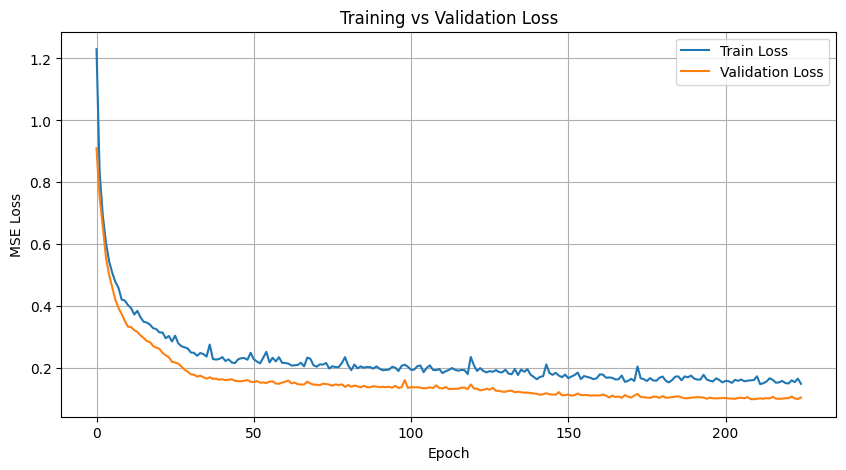

In [22]:
# After training, plot the losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.grid(True)
plt.show()

## Evaluate the model
To test the autoencoder, we need to measure the reconstruction error across normal traffic and abnormal traffic. If the error is much greater across abnormal traffic, we can confirm that it is detecting anomalies.

In [23]:
# Compute reconstruction errors on test set
model.eval()
with torch.no_grad():
  test_reconstructed = model(X_test_tensor)
  reconstruction_errors = torch.mean(
    (X_test_tensor - test_reconstructed) ** 2, dim=1
  ).numpy()

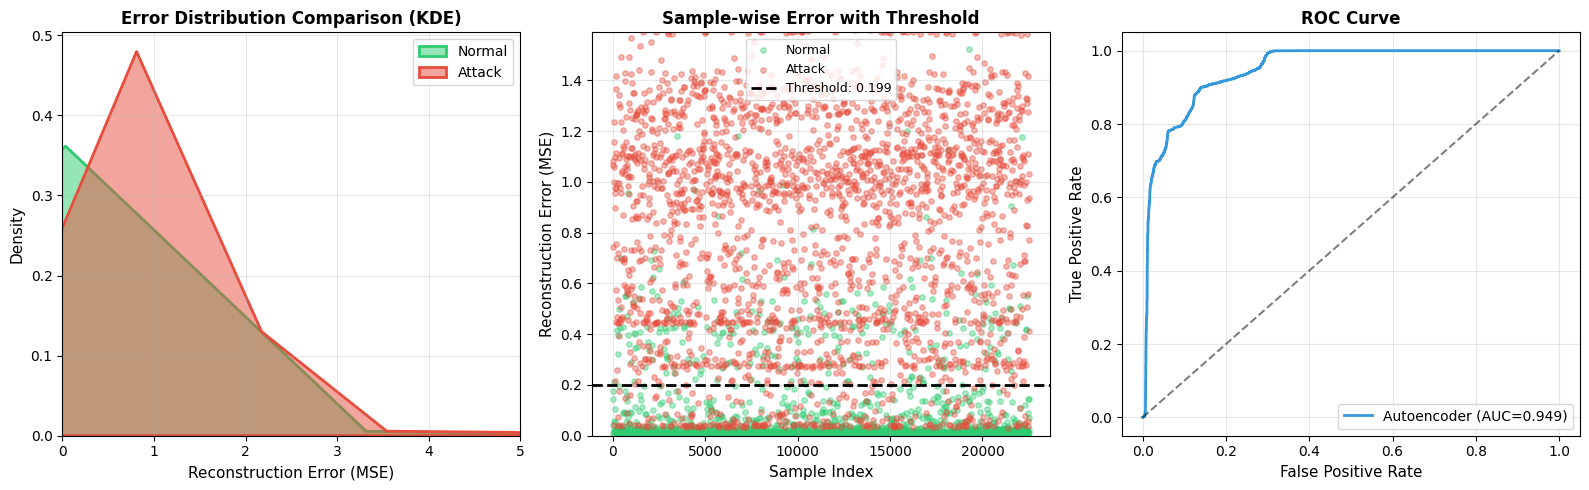

In [28]:
def optimizeThreshold(normal_errors, attack_errors):
  """
  Optimize threshold to maximize both:
  - Normal points below threshold (True Negatives)
  - Attack points above threshold (True Positives)
  
  Objective: maximize (TN_rate + TP_rate) / 2
  
  Returns:
    float: optimal threshold value
  """
  # Combine all errors to get candidate thresholds
  all_errors = np.concatenate([normal_errors, attack_errors])
  candidate_thresholds = np.percentile(all_errors, np.linspace(0, 100, 1000))
  
  best_threshold = None
  best_score = -1
  
  for thresh in candidate_thresholds:
    # Rate of normal samples correctly classified (below threshold)
    tn_rate = np.sum(normal_errors <= thresh) / len(normal_errors)
    
    # Rate of attack samples correctly classified (above threshold)
    tp_rate = np.sum(attack_errors > thresh) / len(attack_errors)
    
    # Objective: maximize average of both rates (balanced accuracy)
    score = (tn_rate + tp_rate) / 2
    
    if score > best_score:
      best_score = score
      best_threshold = thresh
  
  return best_threshold

# Visualize reconstruction error comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Visual 1: KDE (Kernel Density Estimation)
ax1 = axes[0]
normal_errors = reconstruction_errors[y_test == 0]
attack_errors = reconstruction_errors[y_test == 1]

sns.kdeplot(
  normal_errors,
  ax=ax1,
  label='Normal',
  fill=True,
  alpha=0.5,
  color='#2ecc71',
  linewidth=2,
)
sns.kdeplot(
  attack_errors,
  ax=ax1,
  label='Attack',
  fill=True,
  alpha=0.5,
  color='#e74c3c',
  linewidth=2,
)
ax1.set_xlabel('Reconstruction Error (MSE)', fontsize=11)
ax1.set_ylabel('Density', fontsize=11)
ax1.set_title('Error Distribution Comparison (KDE)', fontsize=12, fontweight='bold')
ax1.set_xlim(0, 5)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Visual 2: Sample-wise error with threshold line
ax2 = axes[1]
# Create indices for plotting
normal_indices = np.where(y_test == 0)[0]
attack_indices = np.where(y_test == 1)[0]

# Sample subset to avoid overcrowding (every 10th point)
sample_rate = 5
ax2.scatter(
  normal_indices[::sample_rate],
  normal_errors[::sample_rate],
  alpha=0.4,
  s=15,
  c='#2ecc71',
  label='Normal',
)
ax2.scatter(
  attack_indices[::sample_rate],
  attack_errors[::sample_rate],
  alpha=0.4,
  s=15,
  c='#e74c3c',
  label='Attack',
)

# Add threshold line
threshold = optimizeThreshold(normal_errors, attack_errors)
ax2.axhline(
  y=threshold,
  color='black',
  linestyle='--',
  linewidth=2,
  label=f'Threshold: {threshold:.3f}',
)

# Limit Y-axis to focus on majority of samples (clip outliers)
y_max = np.percentile(reconstruction_errors, 95)  # Show bottom 95% of errors
ax2.set_ylim(0, y_max)

ax2.set_xlabel('Sample Index', fontsize=11)
ax2.set_ylabel('Reconstruction Error (MSE)', fontsize=11)
ax2.set_title('Sample-wise Error with Threshold', fontsize=12, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# Visual 3: ROC Curve
ax3 = axes[2]
fpr, tpr, thresholds = roc_curve(y_test, reconstruction_errors)
roc_auc = roc_auc_score(y_test, reconstruction_errors)
ax3.plot(
  fpr, tpr, label=f'Autoencoder (AUC={roc_auc:.3f})', linewidth=2, color='#3498db'
)
ax3.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax3.set_xlabel('False Positive Rate', fontsize=11)
ax3.set_ylabel('True Positive Rate', fontsize=11)
ax3.set_title('ROC Curve', fontsize=12, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [29]:
# Print statistics (using median for robustness to outliers)
print('--- Error Statistics ---')
print(
  f'Normal median error: {np.median(normal_errors):.4f} (IQR: {np.percentile(normal_errors, 25):.4f} - {np.percentile(normal_errors, 75):.4f})'
)
print(
  f'Attack median error: {np.median(attack_errors):.4f} (IQR: {np.percentile(attack_errors, 25):.4f} - {np.percentile(attack_errors, 75):.4f})'
)

# Count samples above and below threshold
normal_above_threshold = (normal_errors > threshold).sum()
normal_below_threshold = (normal_errors <= threshold).sum()
attack_above_threshold = (attack_errors > threshold).sum()
attack_below_threshold = (attack_errors <= threshold).sum()

print(f'\n--- Threshold Analysis (t={threshold:.3f}) ---')
print('Normal traffic:')
print(
  f'  Below threshold: {normal_below_threshold:,} ({100 * normal_below_threshold / len(normal_errors):.1f}%)'
)
print('Attack traffic:')
print(
  f'  Above threshold: {attack_above_threshold:,} ({100 * attack_above_threshold / len(attack_errors):.1f}%)'
)

--- Error Statistics ---
Normal median error: 0.0160 (IQR: 0.0095 - 0.0619)
Attack median error: 0.9588 (IQR: 0.4516 - 1.2302)

--- Threshold Analysis (t=0.199) ---
Normal traffic:
  Below threshold: 8,350 (86.0%)
Attack traffic:
  Above threshold: 11,547 (90.0%)


In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Create predictions based on threshold
# Above threshold = attack (1), below threshold = normal (0)
y_pred = (reconstruction_errors > threshold).astype(int)

# Calculate metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, reconstruction_errors)

# Print metrics
print('--- Classification Metrics ---')
print(f'Precision: {precision:.4f}')
print(f'Recall:    {recall:.4f}')
print(f'F1 Score:  {f1:.4f}')
print(f'ROC-AUC:   {roc_auc:.4f}')

--- Classification Metrics ---
Precision: 0.8946
Recall:    0.8998
F1 Score:  0.8972
ROC-AUC:   0.9487
